In [1]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [4]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zsxjrg0n
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-zsxjrg0n
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=74ce8f58031f929e569d06bf447f45b8ac2e030b79f3025f677f8bc7fd6f0da0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ra_bp7r/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [7]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.0 MB/s 


In [5]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [8]:
from helper import *

In [10]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 0

train_set, test_set, class_weight, labels = prep_pipeline1(1500, h, w, aug_targets, aug_count, aug_size)

In [78]:
X_train1 = train_set[0]
X_train2 = train_set[1]
y_train_mel = train_set[2][:, 4]
y_train_bcc = train_set[2][:, 1]

X_test1 = test_set[0]
X_test2 = test_set[1]
y_test_mel = test_set[2][:, 4]
y_test_bcc = test_set[2][:, 1]

In [29]:
print(X_train1.shape, X_test1.shape)

(3366, 90, 90, 3) (722, 90, 90, 3)


In [30]:
print(y_train_mel.shape, y_test_mel.shape)

(3366,) (722,)


In [57]:
class_weight_mel = {0 : 1, 1 : 3.72}
class_weight_bcc = {0 : 1, 1 : 8.14}

In [32]:
histories = {}

channels = 3
img_shape = (h, w, channels)

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')      
  ]

In [46]:
def model_builder():
  inputA = tf.keras.Input(shape=(90, 90, 3))
  inputB = tf.keras.Input(shape=(20,))

  base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', pooling='max')(inputA)
  Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(base_model)

  x = tf.keras.layers.Dense(288, activation="relu")(Normalizator_layer)
  image_part = tf.keras.Model(inputs=inputA, outputs=x)

  y = tf.keras.layers.Dense(8, activation="relu")(inputB)
  cate_part = tf.keras.Model(inputs=inputB, outputs=y)

  combined = tf.keras.layers.concatenate([image_part.output, cate_part.output])

  z = tf.keras.layers.Dense(128,
                            kernel_regularizer = regularizers.l2(l = 0.02),
                            activation='relu')(combined)
  z = keras.layers.Dropout(rate=.5, seed=42)(z)
  prediction_layer = keras.layers.Dense(1, activation='sigmoid')(z)

  model = tf.keras.Model(inputs=[image_part.input, cate_part.input], outputs=prediction_layer)

  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [89]:
model = model_builder()
history = model.fit([X_train1, X_train2],
                    y_train_mel, 
                    epochs=40, 
                    validation_split=0.2, 
                    callbacks=get_callbacks(),
                    class_weight=class_weight_mel)

Epoch 1/40
85/85 [==============================] - 25s 129ms/step - loss: 4.4520 - accuracy: 0.5858 - val_loss: 2.9964 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/40
85/85 [==============================] - 8s 99ms/step - loss: 3.1772 - accuracy: 0.7110 - val_loss: 2.6506 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 3/40
85/85 [==============================] - 8s 100ms/step - loss: 2.6528 - accuracy: 0.7823 - val_loss: 2.3060 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 4/40
85/85 [==============================] - 8s 99ms/step - loss: 2.2680 - accuracy: 0.8336 - val_loss: 2.1245 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 5/40
85/85 [==============================] - 8s 99ms/step - loss: 1.9919 - accuracy: 0.8640 - val_loss: 1.9730 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 6/40
85/85 [==============================] - 8s 99ms/step - loss: 1.7693 - accuracy: 0.8889 - val_loss: 1.8180 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 7/40
85/85 [==============================] - 9s 100ms/step - loss:

In [90]:
histories['mel'] = history

In [91]:
pred=model.predict([X_test1, X_test2])
y_pred_mel = np.round(pred)
y_pred_mel = np.array(y_pred_mel)

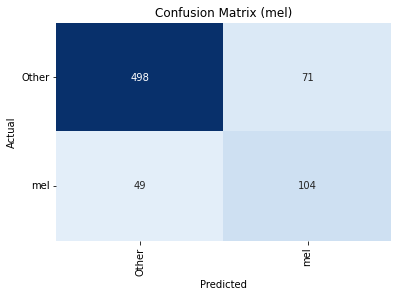

In [98]:
cm = confusion_matrix(y_test_mel, y_pred_mel)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks([0.5, 1.5], ['Other', 'mel'], rotation= 90)
plt.yticks([0.5, 1.5], ['Other', 'mel'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (mel)")
plt.savefig("CM_onevsall_mel.png")

In [101]:
clr = classification_report(y_test_mel, y_pred_mel, target_names=['other','mel'])
print("Classification Report (mel):")
print("=====================================================")
print(clr)

Classification Report (mel):
              precision    recall  f1-score   support

       other       0.91      0.88      0.89       569
         mel       0.59      0.68      0.63       153

    accuracy                           0.83       722
   macro avg       0.75      0.78      0.76       722
weighted avg       0.84      0.83      0.84       722



In [94]:
model = model_builder()
history = model.fit([X_train1, X_train2],
                    y_train_bcc, 
                    epochs=40, 
                    validation_split=0.2, 
                    callbacks=get_callbacks(),
                    class_weight=class_weight_bcc)

Epoch 1/40
85/85 [==============================] - 26s 130ms/step - loss: 4.2435 - accuracy: 0.7017 - val_loss: 2.5921 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 2/40
85/85 [==============================] - 8s 99ms/step - loss: 2.9293 - accuracy: 0.7961 - val_loss: 2.3060 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 3/40
85/85 [==============================] - 8s 99ms/step - loss: 2.2972 - accuracy: 0.8793 - val_loss: 2.0704 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 4/40
85/85 [==============================] - 8s 100ms/step - loss: 2.1311 - accuracy: 0.9064 - val_loss: 2.0034 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 5/40
85/85 [==============================] - 8s 99ms/step - loss: 1.8859 - accuracy: 0.9209 - val_loss: 1.8180 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 6/40
85/85 [==============================] - 8s 100ms/step - loss: 1.7211 - accuracy: 0.9421 - val_loss: 1.7166 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 7/40
85/85 [==============================] - 8s 100ms/step - loss

In [95]:
histories['bcc'] = history

In [96]:
pred=model.predict([X_test1, X_test2])
y_pred_bcc = np.round(pred)
y_pred_bcc = np.array(y_pred_bcc)

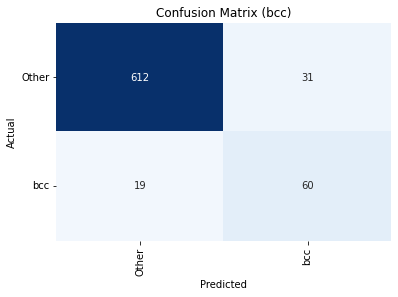

In [99]:
cm = confusion_matrix(y_test_bcc, y_pred_bcc)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks([0.5, 1.5], ['Other', 'bcc'], rotation= 90)
plt.yticks([0.5, 1.5], ['Other', 'bcc'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (bcc)")
plt.savefig("CM_onevsall_bcc.png")

In [100]:
clr = classification_report(y_test_bcc, y_pred_bcc, target_names=['other','bcc'])
print("Classification Report (bcc):")
print("=====================================================")
print(clr)

Classification Report (bcc):
              precision    recall  f1-score   support

       other       0.97      0.95      0.96       643
         bcc       0.66      0.76      0.71        79

    accuracy                           0.93       722
   macro avg       0.81      0.86      0.83       722
weighted avg       0.94      0.93      0.93       722



In [102]:
from sklearn.metrics import roc_curve
fpr_mel, tpr_mel, thresholds_mel = roc_curve(y_test_mel, y_pred_mel)
fpr_bcc, tpr_bcc, thresholds_bcc = roc_curve(y_test_bcc, y_pred_bcc)

In [103]:
from sklearn.metrics import auc
auc_mel = auc(fpr_mel, tpr_mel)
auc_bcc = auc(fpr_bcc, tpr_bcc)

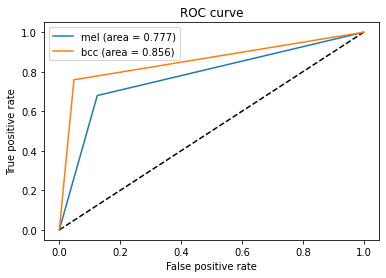

In [105]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mel, tpr_mel, label='mel (area = {:.3f})'.format(auc_mel))
plt.plot(fpr_bcc, tpr_bcc, label='bcc (area = {:.3f})'.format(auc_bcc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC.png")
plt.show()

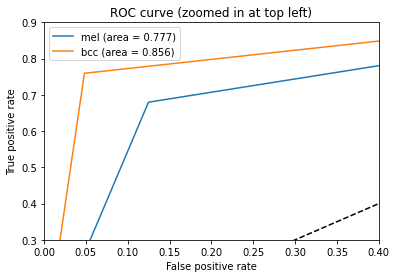

In [107]:
plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.3, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mel, tpr_mel, label='mel (area = {:.3f})'.format(auc_mel))
plt.plot(fpr_bcc, tpr_bcc, label='bcc (area = {:.3f})'.format(auc_bcc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig("ROC_zoom.png")
plt.show()